In [9]:
import pandas as pd

# Load the datasets
ce = pd.read_csv('CE.txt', sep=r'\s+', header=None)
ps1 = pd.read_csv('PS1.txt', sep=r'\s+', header=None)
eps1 = pd.read_csv('EPS1.txt', sep=r'\s+', header=None)
ts1 = pd.read_csv('TS1.txt', sep=r'\s+', header=None)
vs1 = pd.read_csv('VS1.txt', sep=r'\s+', header=None)
labels_df = pd.read_csv("profile.txt", sep=r'\s+', header=None)

# Target variable: 0 = no leakage, 1 = weak, 2 = severe
labels = labels_df[2]

# Check distribution
labels.value_counts()


# Confirm shapes
print("CE:", ce.shape, "PS1:", ps1.shape, "EPS1:", eps1.shape, "TS1:", ts1.shape, "VS1:", vs1.shape)



CE: (2205, 60) PS1: (2205, 6000) EPS1: (2205, 6000) TS1: (2205, 60) VS1: (2205, 60)


In [12]:
# Load sensor data
ps1 = pd.read_csv('PS1.txt', sep=r'\s+', header=None)
eps1 = pd.read_csv('EPS1.txt', sep=r'\s+', header=None)
ts1 = pd.read_csv('TS1.txt', sep=r'\s+', header=None)
vs1 = pd.read_csv('VS1.txt', sep=r'\s+', header=None)

# Simple feature extractor
def extract_features(df, prefix):
    return pd.DataFrame({
        f'{prefix}_mean': df.mean(axis=1),
        f'{prefix}_std': df.std(axis=1),
        f'{prefix}_min': df.min(axis=1),
        f'{prefix}_max': df.max(axis=1),
    })

# Extract and combine features
X = pd.concat([
    extract_features(ps1, 'pressure'),
    extract_features(eps1, 'power'),
    extract_features(ts1, 'temp'),
    extract_features(vs1, 'vib')
], axis=1)

# Confirm shape
print(X.shape)
X.head()


(2205, 16)


,pressure_mean,pressure_std,pressure_min,pressure_max,power_mean,power_std,power_min,power_max,temp_mean,temp_std,temp_min,temp_max,vib_mean,vib_std,vib_min,vib_max
0,160.673492,13.939309,145.83,191.51,2538.929167,185.616121,2339.8,2951.6,35.621983,0.308230,35.156,36.152,0.576950,0.027078,0.532,0.624
1,160.603320,14.118967,145.73,191.47,2531.498900,189.940089,2332.0,2947.4,36.676967,0.585740,35.648,37.488,0.565850,0.027241,0.524,0.626
2,160.347720,14.192619,145.37,191.41,2519.928000,190.736850,2318.6,2939.8,37.880800,0.559169,36.879,38.621,0.576533,0.036729,0.529,0.662
3,160.188088,14.227803,145.14,191.34,2511.541633,191.270607,2310.8,2929.6,38.879050,0.516176,37.887,39.473,0.569267,0.033464,0.527,0.645
4,160.000472,14.276434,144.95,191.41,2503.449500,191.258369,2301.8,2923.8,39.803917,0.535374,38.789,40.391,0.577367,0.033484,0.524,0.660


In [14]:
# Load labels again if not already
labels_df = pd.read_csv('profile.txt', sep=r'\s+', header=None)
labels = (labels_df[2] > 0).astype(int)  # binary: 0 = no leakage, 1 = any leakage
labels.value_counts()



2
0    1221
1     984
Name: count, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[296   0]
 [  1 255]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       296
           1       1.00      1.00      1.00       256

    accuracy                           1.00       552
   macro avg       1.00      1.00      1.00       552
weighted avg       1.00      1.00      1.00       552



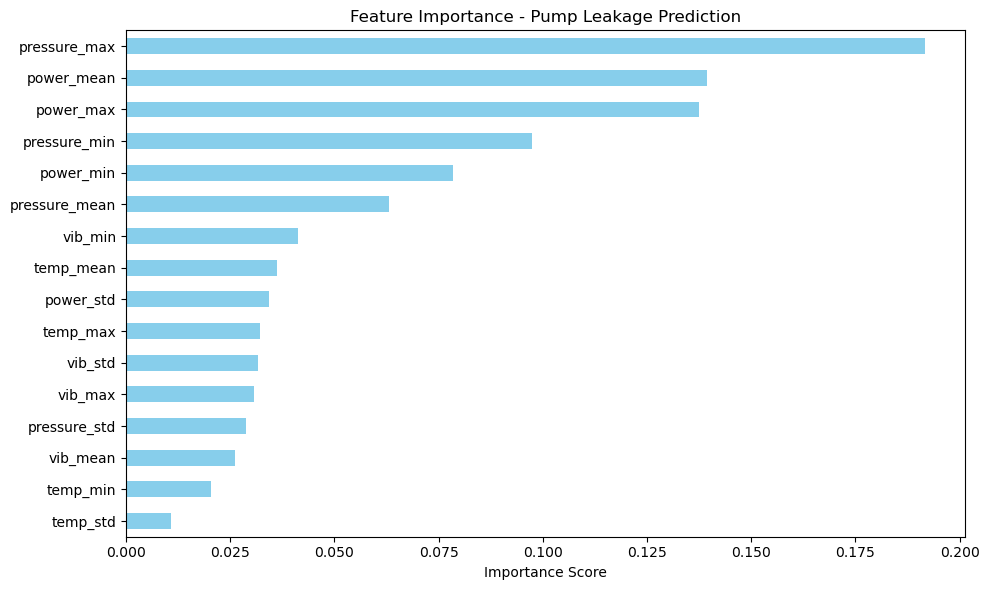

In [16]:
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 6), color='skyblue')

plt.title("Feature Importance - Pump Leakage Prediction")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()
